In [1]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

In [2]:
processed_train_images = np.load('./data/fer_train_processed_images.npy')
processed_train_labels = np.load('./data/fer_train_processed_labels.npy')

In [3]:
print(processed_train_images.shape, processed_train_labels.shape)

(25045, 1, 64, 64) (25045, 8)


In [4]:
from matplotlib import pyplot as plt

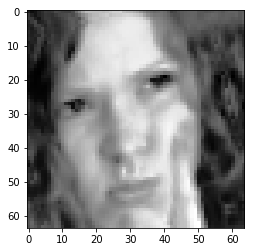

In [5]:
plt.imshow(processed_train_images[234].reshape(64,64), cmap='gray')

In [7]:
processed_test_images = np.load('./data/fer_test_processed_images.npy')
processed_test_labels = np.load('./data/fer_test_processed_labels.npy')
processed_val_images = np.load('./data/fer_val_processed_images.npy')
processed_val_labels = np.load('./data/fer_val_processed_labels.npy')

In [8]:
print(processed_test_images.shape, processed_test_labels.shape)

(3137, 1, 64, 64) (3137, 8)


In [9]:
print(processed_val_images.shape, processed_val_labels.shape)

(3191, 1, 64, 64) (3191, 8)


In [10]:
# Set this to ctx = mx.cpu() if running on CPU. 
# However, please note, it takes approx. 1.1 min/epoch on 1 GPU => Can take longer time on cPU

ctx = mx.gpu()

In [11]:
# 13 layer VGGNet
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Conv2D(channels=128, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=128, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(1024, activation='relu'))
    net.add(gluon.nn.Dropout(0.5))
    net.add(gluon.nn.Dense(1024, activation='relu'))
    net.add(gluon.nn.Dropout(0.5))
    net.add(gluon.nn.Dense(8))

In [12]:
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
nd.waitall()

In [13]:
# Use MXBOARD here to visualize network
# x = mx.sym.var('data')
# sym = net(x)
# mx.viz.plot_network(sym)

In [14]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [15]:
batch_size = 32

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0025, 'momentum':0.9})

In [16]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [17]:
train_labels = np.argmax(processed_train_labels, axis=1)
val_labels = np.argmax(processed_val_labels, axis=1)

train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_train_images, train_labels), batch_size = batch_size, shuffle=True)
val_data = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_val_images, val_labels), batch_size = batch_size)

In [ ]:
epochs = 100

train_accuracies = []
losses = []
val_accuracies = []

for e in range(epochs):
    batch = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        curr_loss = nd.mean(loss).asscalar()
        batch +=1        

    val_accuracy = evaluate_accuracy(val_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    
    losses.append(curr_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, curr_loss, train_accuracy, val_accuracy))
    

Epoch 0. Loss: 2.07468, Train_acc 0.208265122779, Test_acc 0.194923221561
Epoch 1. Loss: 2.07729, Train_acc 0.208265122779, Test_acc 0.194923221561
Epoch 2. Loss: 2.07774, Train_acc 0.208265122779, Test_acc 0.194923221561
Epoch 3. Loss: 2.08664, Train_acc 0.208265122779, Test_acc 0.194923221561
Epoch 4. Loss: 2.08884, Train_acc 0.208265122779, Test_acc 0.194923221561
Epoch 5. Loss: 2.08091, Train_acc 0.208265122779, Test_acc 0.194923221561
Epoch 6. Loss: 2.08608, Train_acc 0.208265122779, Test_acc 0.194923221561
Epoch 7. Loss: 2.07691, Train_acc 0.208265122779, Test_acc 0.194923221561
Epoch 8. Loss: 2.08907, Train_acc 0.208265122779, Test_acc 0.194923221561
Epoch 9. Loss: 2.0777, Train_acc 0.208265122779, Test_acc 0.194923221561
Epoch 10. Loss: 2.07125, Train_acc 0.208265122779, Test_acc 0.194923221561
Epoch 11. Loss: 2.07999, Train_acc 0.208265122779, Test_acc 0.194923221561
Epoch 12. Loss: 2.0735, Train_acc 0.208265122779, Test_acc 0.194923221561
Epoch 13. Loss: 2.08091, Train_acc 0.

In [ ]:
# Test accuracy

acc = mx.metric.Accuracy()
test_labels = np.argmax(processed_test_labels, axis=1)
data_iterator = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_test_images, test_labels), batch_size = 32)
for i, (data, label) in enumerate(data_iterator):
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    output = net(data)
    predictions = nd.argmax(output, axis=1)
    acc.update(preds=predictions, labels=label)
print(acc.get()[1])

In [ ]:
# for plotting purposes
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

epochs = range(len(train_accuracies))

f = plt.figure(figsize=(12,6))
fg1 = f.add_subplot(121)
fg2 = f.add_subplot(122)

fg1.set_xlabel('epoch',fontsize=14)  
fg1.set_title('Loss over Training')
fg1.grid(True, which="both")
fg1.plot(epochs, losses)

fg2.set_title('Comparing accuracy')
fg2.set_xlabel('epoch', fontsize=14)
fg2.grid(True, which="both")

p1, = fg2.plot(epochs, train_accuracies)
p2, = fg2.plot(epochs, val_accuracies)
fg2.legend([p1, p2], ['training accuracy', 'testing accuracy'],fontsize=14)